# Open your new rest

this repo includes insightful data analysis and visualizations on cafes and restaurants which are reviewed and rated on df2 in Bangkok

In [3]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from plotly import tools
import re
from plotly.offline import init_notebook_mode, plot, iplot


## PrePro

### read

In [4]:
df = pd.read_csv('./dbs/zomato.csv')

In [5]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [6]:
df.info()
# we can fill nulls in location column with adress column info and also fill rates with rates in review_list rates 
# dish liked nulls fill be filled with None value to imply nothing we can't drop null values in the column
# url adress phone columns are useless for our analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df = df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})

In [9]:
df['rate']

0         4.1/5
1         4.1/5
2         3.8/5
3         3.7/5
4         3.8/5
          ...  
51712    3.6 /5
51713       NaN
51714       NaN
51715    4.3 /5
51716    3.4 /5
Name: rate, Length: 51717, dtype: object

#### Deal columns one by one

##### menu_item

In [10]:
df.loc[df['menu_item'] != '[]'].count()
# nearly 4/5 of columns don't have menu item info maybe it is better the drop menu_item column

url             12100
address         12100
name            12100
online_order    12100
book_table      12100
rate            11383
votes           12100
phone           11983
location        12100
rest_type       12060
dish_liked       6852
cuisines        12095
cost            12100
reviews_list    12100
menu_item       12100
type            12100
city            12100
dtype: int64

In [11]:
df['dish_liked'].iloc[1500]

nan

##### reviews_list
we will check nan values in rate column and try to fill them with rates in reviews_list if rate is null and reviews_list = [] we will drop the row

In [12]:
df['rate'].isnull().value_counts()
# we have 7775 null rate

False    43942
True      7775
Name: rate, dtype: int64

In [13]:
df2= df.copy()

In [14]:
df2[df2['reviews_list']=='[]'].count()

url             7595
address         7595
name            7595
online_order    7595
book_table      7595
rate            2321
votes           7595
phone           7337
location        7574
rest_type       7525
dish_liked       183
cuisines        7565
cost            7543
reviews_list    7595
menu_item       7595
type            7595
city            7595
dtype: int64

In [15]:
prr = df[df['rate'].isna()]

In [16]:
prr[prr['reviews_list'] != '[]'].count()
# we can fill 2501 of nan rate

url             2501
address         2501
name            2501
online_order    2501
book_table      2501
rate               0
votes           2501
phone           2348
location        2501
rest_type       2492
dish_liked        27
cuisines        2495
cost            2452
reviews_list    2501
menu_item       2501
type            2501
city            2501
dtype: int64

In [17]:
indi  = prr[prr['reviews_list'] == '[]' ].index
df2.drop(indi,inplace=True)

In [18]:
df2[df2['rate'].isna()].count()

url             2501
address         2501
name            2501
online_order    2501
book_table      2501
rate               0
votes           2501
phone           2348
location        2501
rest_type       2492
dish_liked        27
cuisines        2495
cost            2452
reviews_list    2501
menu_item       2501
type            2501
city            2501
dtype: int64

In [19]:
df2.reset_index(inplace=True)

In [20]:
df2['rate'].isna().value_counts()
# we are going to fill this 2501 rate row now

False    43942
True      2501
Name: rate, dtype: int64

In [21]:
pat = re.compile('Rated [0-9]*\.[0-9]+',)
cs = []
for i in range(len(df2['reviews_list'])):

    rates = pat.findall(df2['reviews_list'][i])
    k = 0
    
    for rate in rates:
        k = k+int(rate.split('Rated ')[1].split('.')[0])
    if len(rates) != 0:
        if(pd.isnull(df2['rate'][i])):
            k = k/len(rates)
            cs.append(round(k,2))
        else:
            cs.append(df2['rate'][i])
    else:
        cs.append(df2['rate'][i])
    # [int(rate.split('Rated ')[1].split('.')[0]) for rate in rates]

In [22]:
df2['rate']

0         4.1/5
1         4.1/5
2         3.8/5
3         3.7/5
4         3.8/5
          ...  
46438       NaN
46439    2.5 /5
46440    3.6 /5
46441    4.3 /5
46442    3.4 /5
Name: rate, Length: 46443, dtype: object

In [23]:

for i in range(len(df2['rate'])):
    df2['rate'][i] = cs[i]
df2['rate']

C:\Users\emreb\AppData\Local\Temp\ipykernel_9536\4222410133.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0         4.1/5
1         4.1/5
2         3.8/5
3         3.7/5
4         3.8/5
          ...  
46438       4.0
46439    2.5 /5
46440    3.6 /5
46441    4.3 /5
46442    3.4 /5
Name: rate, Length: 46443, dtype: object

In [24]:
df2['rate'].isna().value_counts()

False    46443
Name: rate, dtype: int64

In [25]:
df2.loc[df2['rate']=='NEW']

,index,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
72,72,https://www.zomato.com/bangalore/spicy-tandoor...,"Opposite ICICi Bank, Hanuman Nagar, Banashanka...",Spicy Tandoor,No,No,NEW,0,+91 8050884222,Banashankari,Quick Bites,NaN,North Indian,150,"[('Rated 4.0', 'RATED\n cost for chicken roll...",[],Delivery,Banashankari
75,75,https://www.zomato.com/bangalore/om-sri-vinaya...,"39, S B M Colony, Near-Sita Circle, 1st Stage,...",Om Sri Vinayaka Chats,No,No,NEW,0,+91 8553206035,Banashankari,"Takeaway, Delivery",NaN,"Street Food, Fast Food",500,[],[],Delivery,Banashankari
107,110,https://www.zomato.com/bangalore/hari-super-sa...,"594, 24 The Cross BSK, Opposte Oriental Bank, ...",Hari Super Sandwich,No,No,NEW,0,+91 9886722163,Banashankari,"Takeaway, Delivery",NaN,"Sandwich, Pizza, Beverages",200,"[('Rated 1.0', 'RATED\n I have been here many...",[],Delivery,Banashankari
119,130,https://www.zomato.com/bangalore/roll-magic-fa...,"28, 4th Cross Road, Dwaraka Nagar, Banashankar...",Roll Magic Fast Food,No,No,NEW,0,+91 9731409204,Banashankari,"Takeaway, Delivery",NaN,"Biryani, Rolls, Chinese",200,[],[],Delivery,Banashankari
120,131,https://www.zomato.com/bangalore/foodlieious-m...,"3/16, 22 Main Road, Magenta Block, PES College...",Foodlieious Multi Cuisine,No,No,NEW,0,+91 9168753522\r\n+91 8217877100,Banashankari,Quick Bites,NaN,North Indian,100,[],[],Delivery,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46326,51585,https://www.zomato.com/bangalore/wow-tiffin-fo...,"Near Rama Temple, Immadihalli Road, Whitefield...",Wow Tiffin Food,No,No,NEW,0,+91 9535041209,Whitefield,Quick Bites,NaN,North Indian,200,[],[],Dine-out,Whitefield
46327,51586,https://www.zomato.com/bangalore/quick-bites-w...,"119/5, Pattandur Agrahara, Near Brigade Tech p...",Quick Bites,Yes,No,NEW,0,+91 9742377087\n+91 7899303299,Whitefield,Quick Bites,NaN,Chinese,200,"[('Rated 5.0', 'RATED\n This is an awesome pl...","['Veg Chowmein + Manchurian', 'Paratha + Chick...",Dine-out,Whitefield
46343,51603,https://www.zomato.com/bangalore/shiv-sagar-1-...,"Shop No 10, Food Court, 2nd Floor, Phoenix Mar...",Shiv sagar,Yes,No,NEW,0,+91 9513300048\n+91 8067266097,Whitefield,"Quick Bites, Food Court",NaN,"South Indian, Chinese, North Indian",250,"[('Rated 3.0', 'RATED\n A highly expensive pl...","['Malai Paneer Tikka', 'Paneer Kofta', 'Mushro...",Dine-out,Whitefield
46344,51604,https://www.zomato.com/bangalore/nawab-di-biry...,"17, Thubarahalli Village, Hobli, Varthur Main ...",Nawab Di Biryani,No,No,NEW,0,+91 7899298400\n+91 9818654628,Whitefield,"Takeaway, Delivery",NaN,"Biryani, Mughlai",400,"[('Rated 3.0', 'RATED\n Biriyani had ordered ...",[],Dine-out,Whitefield


In [26]:
df2 = df2.loc[df2.rate !='NEW']
df2 = df2.loc[df2.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
df2.rate = df2.rate.apply(remove_slash).str.strip().astype('float')
df2['rate'].head()

C:\Users\emreb\AppData\Local\Temp\ipykernel_9536\1872025914.py:3: DeprecationWarning:

`np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [27]:
df2.info()
# rest_type has a tiny misings, dish_liked is I donnow, we can fill approx_cost with mean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44166 entries, 0 to 44165
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         44166 non-null  int64  
 1   url           44166 non-null  object 
 2   address       44166 non-null  object 
 3   name          44166 non-null  object 
 4   online_order  44166 non-null  object 
 5   book_table    44166 non-null  object 
 6   rate          41665 non-null  float64
 7   votes         44166 non-null  int64  
 8   phone         43199 non-null  object 
 9   location      44166 non-null  object 
 10  rest_type     44008 non-null  object 
 11  dish_liked    23489 non-null  object 
 12  cuisines      44149 non-null  object 
 13  cost          43870 non-null  object 
 14  reviews_list  44166 non-null  object 
 15  menu_item     44166 non-null  object 
 16  type          44166 non-null  object 
 17  city          44166 non-null  object 
dtypes: float64(1), int64(2), o

#### Approx_cost

In [28]:
df3 = df2.copy()

In [29]:
df3.dropna(inplace=True,subset='cost')

In [30]:
df3.reset_index(inplace=True)

In [31]:
df3['cost'] = df3['cost'].astype(str).apply(lambda x: x.replace(',', ''))

In [32]:
df4=df3.copy()

In [ ]:
def convertto_int(df,columns):
    for col in columns:
        for i in range(len(df[col])):
            if pd.isnull(df[col][i]) == False:
                df[col] = df[col].astype('int64')
            else:
                pass

col = ['cost']
convertto_int(df4,col)

In [125]:
pd.to_numeric(df4['cost'])

0         800
1         800
2         800
3         300
4         600
         ... 
43864     800
43866     800
43867    1500
43868    2500
43869    1500
Name: cost, Length: 41263, dtype: int64

In [128]:
type(df4['rate'][1])

numpy.float64

In [34]:
df4['cost'].isna().value_counts()

False    43870
Name: cost, dtype: int64

In [35]:
# df2['cost'].fillna(df2['cost'].mean())

In [36]:
df4= df4.drop(['url','phone'],axis=1)

In [37]:
df4= df4.drop('dish_liked',axis=1)

In [38]:
df4.dropna(inplace=True)
df4.reset_index(drop=True)

,level_0,index,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,0,0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,1,1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,2,2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,3,3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,4,4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41258,44160,51709,"136, SAP Labs India, KIADB Export Promotion In...",The Farm House Bar n Grill,No,No,3.7,34,Whitefield,"Casual Dining, Bar","North Indian, Continental",800,"[('Rated 4.0', 'RATED\n Ambience- Big and spa...",[],Pubs and bars,Whitefield
41259,44162,51711,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5,81,Whitefield,"Casual Dining, Bar","Andhra, South Indian, Chinese, North Indian",800,"[('Rated 4.0', 'RATED\n A fine place to chill...",[],Pubs and bars,Whitefield
41260,44163,51712,"Four Points by Sheraton Bengaluru, 43/3, White...",Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6,27,Whitefield,Bar,Continental,1500,"[('Rated 5.0', ""RATED\n Food and service are ...",[],Pubs and bars,Whitefield
41261,44164,51715,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3,236,"ITPL Main Road, Whitefield",Bar,Finger Food,2500,"[('Rated 4.0', 'RATED\n Nice and friendly pla...",[],Pubs and bars,Whitefield


In [39]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41263 entries, 0 to 43869
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   level_0       41263 non-null  int64  
 1   index         41263 non-null  int64  
 2   address       41263 non-null  object 
 3   name          41263 non-null  object 
 4   online_order  41263 non-null  object 
 5   book_table    41263 non-null  object 
 6   rate          41263 non-null  float64
 7   votes         41263 non-null  int64  
 8   location      41263 non-null  object 
 9   rest_type     41263 non-null  object 
 10  cuisines      41263 non-null  object 
 11  cost          41263 non-null  object 
 12  reviews_list  41263 non-null  object 
 13  menu_item     41263 non-null  object 
 14  type          41263 non-null  object 
 15  city          41263 non-null  object 
dtypes: float64(1), int64(3), object(12)
memory usage: 5.4+ MB


In [40]:
geolocator=Nominatim(user_agent="app")


In [41]:
locations=pd.DataFrame({"Name":df4['location'].unique()})

In [42]:
len(locations)

92

In [43]:
lat=[]
lon=[]
for location in locations['Name']:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)

In [44]:
locations['lat']=lat
locations['lon']=lon

#### Brand Loc

In [167]:
brand_loc  = pd.DataFrame(df4['name'].value_counts().reset_index())
brand_loc.columns=['Name','count']

In [168]:
brand_loc

,Name,count
0,Cafe Coffee Day,86
1,Onesta,85
2,Empire Restaurant,69
3,Five Star Chicken,68
4,Kanti Sweets,68
...,...,...
6597,Saffron - Radisson Blu,1
6598,Silver Spoon,1
6599,Le Jardin By Bhagini,1
6600,The Kick-Ass Company Pub & Diner,1


In [171]:
brands=pd.DataFrame({"Name":df4['name'].unique()})

In [172]:
lat=[]
lon=[]
for location in brands['Name']:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)


KeyboardInterrupt



In [170]:
brands

,Name,count
0,Cafe Coffee Day,86
1,Onesta,85
2,Empire Restaurant,69
3,Five Star Chicken,68
4,Kanti Sweets,68
...,...,...
6597,Saffron - Radisson Blu,1
6598,Silver Spoon,1
6599,Le Jardin By Bhagini,1
6600,The Kick-Ass Company Pub & Diner,1


In [161]:
brand_loc=brand_loc.merge(brands,on='Name',how="left").dropna()

In [162]:
b_map =  basemap=generateBaseMap()

In [ ]:

for i in range(0,len(brand_loc)):
   folium.Circle(
      location=[brand_loc.iloc[i]['lat'], brand_loc.iloc[i]['lon']],
      popup=brand_loc.iloc[i]['Name'],
      radius=float(brand_loc.iloc[i]['count']),
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(b_map)

# Show the map again
b_map

#### Rest loc

In [45]:
Rest_locations=pd.DataFrame(df4['location'].value_counts().reset_index())

In [46]:
Rest_locations.columns=['Name','count']
Rest_locations.head()

,Name,count
0,BTM,3879
1,Koramangala 5th Block,2297
2,HSR,1993
3,Indiranagar,1800
4,JP Nagar,1710


In [47]:
print(locations.shape)
print(Rest_locations.shape)

(92, 3)
(92, 2)


In [48]:
Restaurant_locations=Rest_locations.merge(locations,on='Name',how="left").dropna()
Restaurant_locations.head()

,Name,count,lat,lon
0,BTM,3879,45.954851,-112.496595
1,Koramangala 5th Block,2297,12.934843,77.618977
2,HSR,1993,18.147500,41.538889
3,Indiranagar,1800,12.973291,77.640467
4,JP Nagar,1710,12.265594,76.646540


In [49]:
def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, zoom_start=default_zoom_start)
    return base_map

In [50]:
basemap=generateBaseMap()

In [ ]:
basemap

In [150]:
Restaurant_locations[['lat','lon','count']]

,Name,count,lat,lon
0,BTM,3879,45.954851,-112.496595
1,Koramangala 5th Block,2297,12.934843,77.618977
2,HSR,1993,18.147500,41.538889
3,Indiranagar,1800,12.973291,77.640467
4,JP Nagar,1710,12.265594,76.646540
...,...,...,...,...
87,Yelahanka,4,13.100698,77.596345
88,West Bangalore,3,12.984852,77.540063
89,Rajarajeshwari Nagar,2,12.927441,77.515522
90,Nagarbhavi,1,12.959618,77.511267


In [53]:
HeatMap(Restaurant_locations[['lat','lon','count']],zoom=20,radius=15).add_to(basemap)

In [54]:
basemap

In [55]:
FastMarkerCluster(data=Restaurant_locations[['lat','lon','count']].values.tolist()).add_to(basemap)

basemap

In [56]:
type(df4['rate'][4])

numpy.float64

In [57]:
df4.groupby(['location'])['rate'].mean().sort_values(ascending=False)

location
Lavelle Road             4.141788
Koramangala 3rd Block    4.020419
St. Marks Road           4.017201
Koramangala 5th Block    4.006661
Church Street            3.992125
                           ...   
Rammurthy Nagar          3.346154
North Bangalore          3.340000
Peenya                   3.200000
Bommanahalli             3.190972
Old Madras Road          3.181818
Name: rate, Length: 92, dtype: float64

In [58]:
avg_rating=df4.groupby(['location'])['rate'].mean().values


In [59]:
loc=df4.groupby(['location'])['rate'].mean().index

In [60]:
loc

Index(['BTM', 'Banashankari', 'Banaswadi', 'Bannerghatta Road', 'Basavanagudi',
       'Basaveshwara Nagar', 'Bellandur', 'Bommanahalli', 'Brigade Road',
       'Brookefield', 'CV Raman Nagar', 'Central Bangalore', 'Church Street',
       'City Market', 'Commercial Street', 'Cunningham Road', 'Domlur',
       'East Bangalore', 'Ejipura', 'Electronic City', 'Frazer Town',
       'HBR Layout', 'HSR', 'Hebbal', 'Hennur', 'Hosur Road',
       'ITPL Main Road, Whitefield', 'Indiranagar', 'Infantry Road',
       'JP Nagar', 'Jalahalli', 'Jayanagar', 'Jeevan Bhima Nagar', 'KR Puram',
       'Kaggadasapura', 'Kalyan Nagar', 'Kammanahalli', 'Kanakapura Road',
       'Kengeri', 'Koramangala', 'Koramangala 1st Block',
       'Koramangala 2nd Block', 'Koramangala 3rd Block',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block',
       'Koramangala 8th Block', 'Kumaraswamy Layout', 'Langford Town',
       'Lavelle Road', 'MG Road', 'Magadi

In [61]:
geolocator=Nominatim(user_agent="app")

In [62]:
lat=[]
lon=[]
for location in loc:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)

In [63]:
rating=pd.DataFrame()
rating['location']=loc
rating['lat']=lat
rating['lon']=lon
rating['avg_rating']=avg_rating

In [64]:
rating=rating.dropna()

In [65]:
HeatMap(rating[['lat','lon','avg_rating']],zoom=20,radius=15).add_to(basemap)
basemap

In [66]:
df2= df4[df4['cuisines']=='North Indian']
df2.head()

,level_0,index,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
5,5,5,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,Yes,No,3.8,286,Basavanagudi,Casual Dining,North Indian,600,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari
50,50,50,"276, Ground Floor, 100 Feet Outer Ring Road, B...",Petoo,No,No,3.7,21,Banashankari,Quick Bites,North Indian,450,"[('Rated 2.0', 'RATED\n This is a neatly made...",[],Delivery,Banashankari
85,85,87,"38, 22nd Main, 22nd Cross, Opposite BDA, 2nd S...",Krishna Sagar,No,No,3.5,31,Banashankari,Quick Bites,North Indian,200,"[('Rated 1.0', 'RATED\n Worst experience with...",[],Delivery,Banashankari
90,90,94,"304, Opposite Apollo Public School, 100 Feet R...",Nandhini Deluxe,No,No,2.6,283,Banashankari,Casual Dining,North Indian,600,"[('Rated 3.0', 'RATED\n Ididnt like much.\n\n...",[],Delivery,Banashankari
104,104,109,"8, Katriguppe Main Road, Vivekananda Nagar, 3r...",Katriguppe Donne Biryani,No,No,3.2,4,Banashankari,Quick Bites,North Indian,300,[],[],Delivery,Banashankari


In [101]:
plt.rcParams["figure.figsize"] = (11,7)

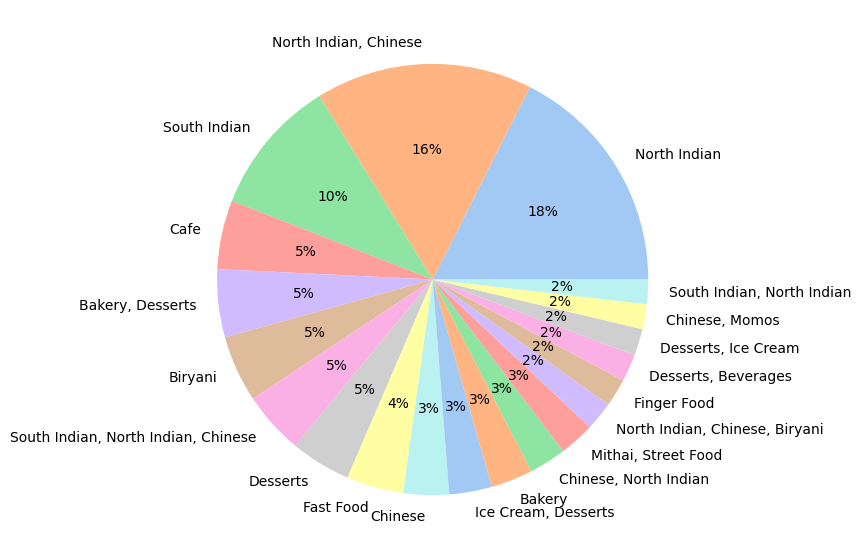

In [120]:
values = df4['cuisines'].value_counts()[:20]
labels=values.index
text=values.index

colors = sns.color_palette('pastel')[0:len(labels)]
plt.pie(values.values, labels=labels, colors=colors,autopct='%.0f%%')
# displaying chart
plt.show()

<AxesSubplot: xlabel='cost', ylabel='online_order'>

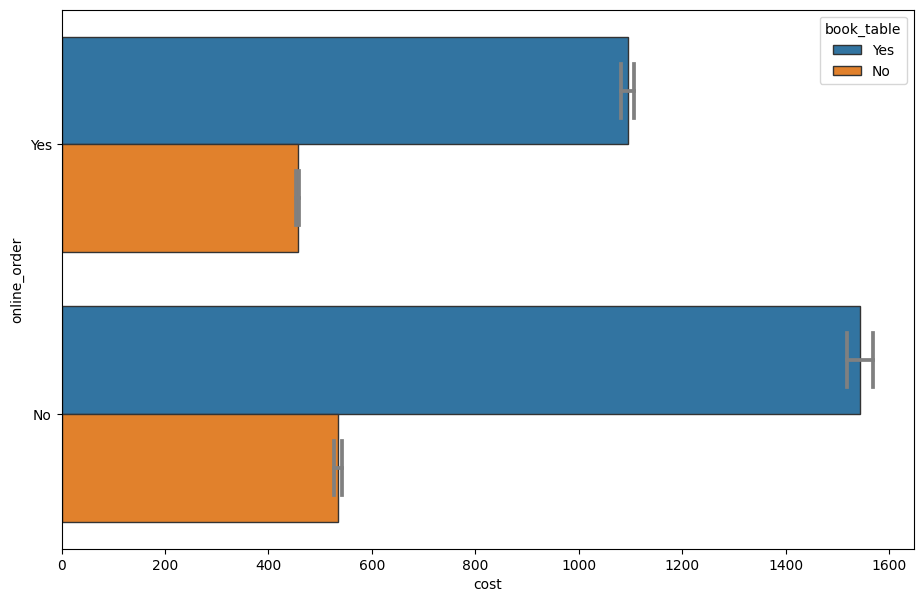

In [141]:
sns.barplot(df4,x='cost',y='online_order',linewidth=1, edgecolor=".2",capsize=.2, errcolor=".5",orient="h",hue='book_table')
# e expect book table more available on restaurants which doesn't accept online orders

<AxesSubplot: xlabel='cost', ylabel='city'>

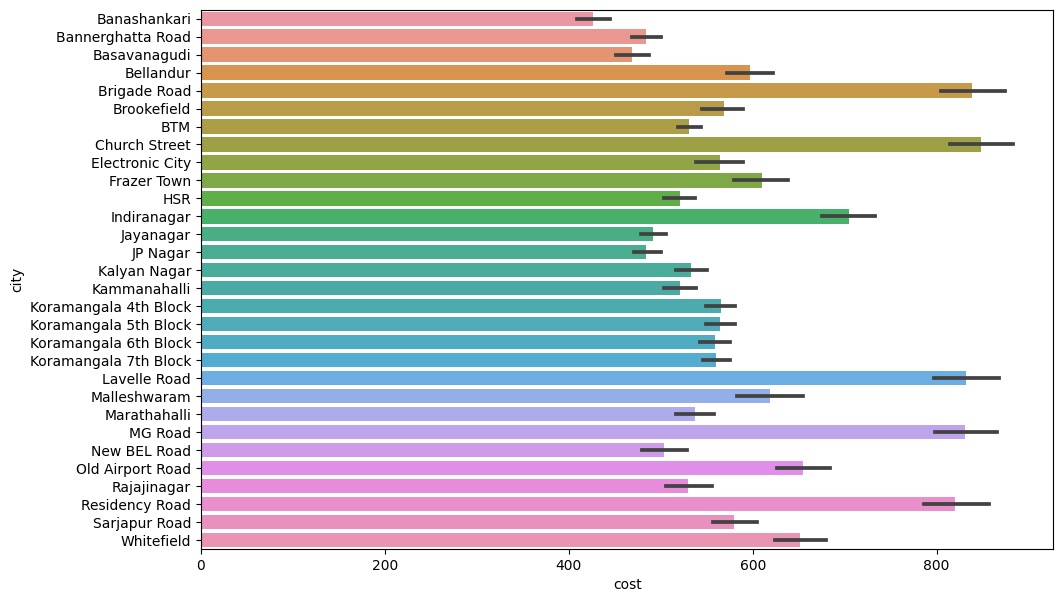

In [148]:
sns.barplot(df4,x='cost',y='city',orient="h")

In [146]:
df4.type.nunique()

7